        E:\Data\FinalResults\Dsp\0861 - Pre-Initialization Cross-day Stability is already existed!
[1 2 3 4 5 6]
R1:
  Ctrl: LinregressResult(slope=0.004346510841653376, intercept=0.7181261415673483, rvalue=0.09841596459666024, pvalue=0.6473023929741573, stderr=0.009370233169672705, intercept_stderr=0.028369789774135627)
  Exp.: LinregressResult(slope=0.026783161548184546, intercept=0.3011043043137975, rvalue=0.31978668444594194, pvalue=0.12767873598408291, stderr=0.01691860534910268, intercept_stderr=0.05122362147604645)
  Paired T-test Exp.: TtestResult(statistic=-1.3548929429308074, pvalue=0.13422555656042187, df=3)
  Paired T-test Ctrl: TtestResult(statistic=-0.885379095690334, pvalue=0.22058042105400932, df=3)
R2:
  Ctrl: LinregressResult(slope=0.009627047942238122, intercept=0.6800421968550215, rvalue=0.2432072049775289, pvalue=0.252142887042345, stderr=0.008185884470713074, intercept_stderr=0.024783996016355597)
  Exp.: LinregressResult(slope=0.041629563555716106, intercept=0.25

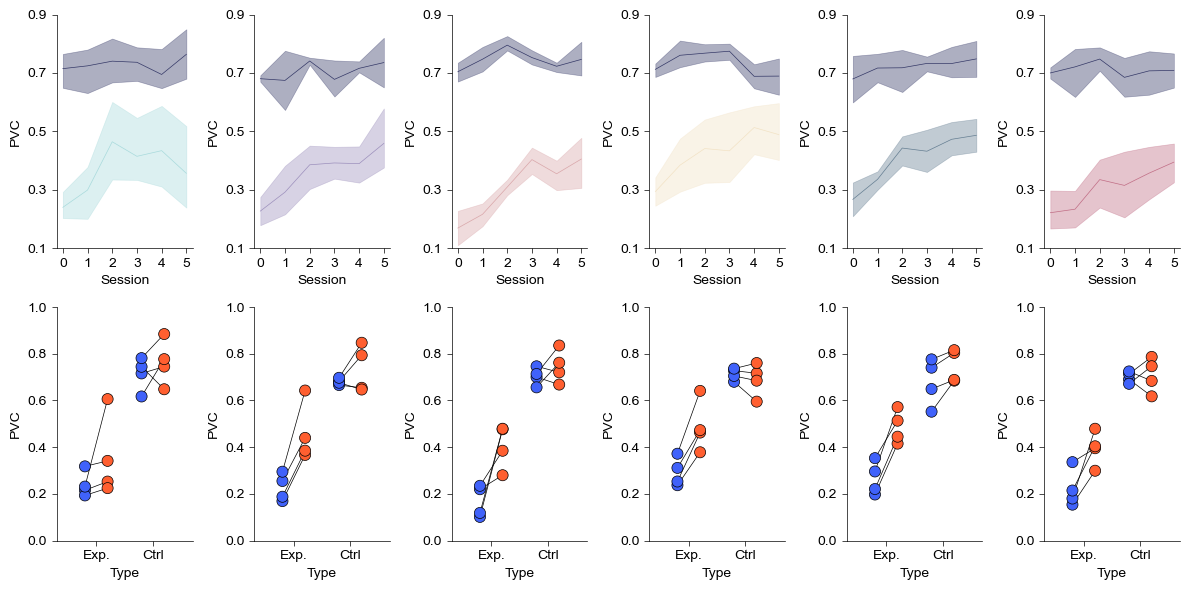

In [1]:
from mylib.statistic_test import *

code_id = "0861 - Pre-Initialization Cross-day Stability"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

if exists(join(figdata, f"{code_id}.pkl")) == False:
    Data = {
        "PVC": [],
        "Session": [],
        "MiceID": [],
        "Route": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        print(mouse, "------------------")
        cellreg_idx = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
        
        with open(f_CellReg_dsp['cellreg_folder'][cellreg_idx], 'rb') as handle:
            index_map = pickle.load(handle).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
            
        cell_counts = np.sum(np.where(index_map >= 1, 1, 0), axis=0)
        cell_idx = np.where(cell_counts == 7)[0]
        
                
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for i in tqdm(range(6)):
            with open(f2['Trace File'][file_idx[i]], 'rb') as handle:
                trace1 = pickle.load(handle)
                
            with open(f2['Trace File'][file_idx[i + 1]], 'rb') as handle:
                trace2 = pickle.load(handle)
            
            corrs = np.zeros(6, np.float64)
            corrs_ctrl = np.zeros(6, np.float64)
            rs = np.array([0, 1, 2, 3, 0, 0, 4, 5, 6, 0])
            bin_id = [
                CP_DSP[j][:3] for j in range(1, 2)
            ] + [
                CP_DSP[j][:5] for j in range(2, 7)
            ]     
            bin_id = [
                np.concatenate([Father2SonGraph[j] for j in bin_id[k]]) for k in range(6)
            ]
            bin_id_ctrl = [
                CP_DSP[1][:3],
                CP_DSP[2][:5],
                CP_DSP[3][:5],
                CP_DSP[4][2:7],
                CP_DSP[5][3:8],
                CP_DSP[6][4:9],
            ]
            bin_id_ctrl = [
                np.concatenate([Father2SonGraph[j] for j in bin_id_ctrl[k]]) for k in range(6)
            ]
            nodes = np.array([1, 2, 3, 6, 7, 8])

            is_pc1_r0 = np.where(np.sum(np.vstack([
                trace1[f'node {j}']['is_placecell'] for j in [0, 4, 5, 9]
            ]), axis=0) >= 1, 1, 0)
            is_pc2_r0 = np.where(np.sum(np.vstack([
                trace2[f'node {j}']['is_placecell'] for j in [0, 4, 5, 9]
            ]), axis=0) >= 1, 1, 0)

            for r in range(1, 7):
                is_placecell1 = np.where(is_pc1_r0+trace1[f'node {nodes[r-1]}']['is_placecell']>=1, 1, 0)
                is_placecell2 = np.where(is_pc2_r0+trace2[f'node {nodes[r-1]}']['is_placecell']>=1, 1, 0)
                cell_idx = np.where(
                    (index_map[i, :] >= 1) & 
                    (index_map[i + 1, :] >= 1) &
                    (is_placecell1[index_map[i, :]-1] == 1) &
                    (is_placecell2[index_map[i + 1, :]-1] == 1)
                )[0]
                print(f"  R{r+1} D{i+1}->{i+2}     {cell_idx.shape[0]}")    
                map_ctrl1 = np.mean(np.stack([
                    trace1[f'node {j}']['smooth_map_all'][index_map[i, cell_idx]-1, :] for j in [0, 4, 5, 9]
                ], axis=2), axis=2) 
                    
                map_ctrl2 = np.mean(np.stack([
                    trace2[f'node {j}']['smooth_map_all'][index_map[i+1, cell_idx]-1, :] for j in [0, 4, 5, 9]
                ], axis=2), axis=2)
                    
                corrs[r-1] = np.corrcoef(
                    trace1[f"node {nodes[r-1]}"]["smooth_map_all"][index_map[i, cell_idx]-1, :][:, bin_id[r-1]-1].flatten(),
                    trace2[f"node {nodes[r-1]}"]["smooth_map_all"][index_map[i+1, cell_idx]-1, :][:, bin_id[r-1]-1].flatten(),
                )[0, 1]
                    
                corrs_ctrl[r-1] = np.corrcoef(
                    map_ctrl1[:, bin_id_ctrl[r-1]-1].flatten(),
                    map_ctrl2[:, bin_id_ctrl[r-1]-1].flatten(),
                )[0, 1]
                    
            Data['MiceID'].append(np.repeat(mouse, 6*2))
            Data['Session'].append(np.repeat(i, 6*2))
            Data['Route'] += [np.arange(1, 7)] * 2
            Data['PVC'] += [corrs.flatten(), corrs_ctrl.flatten()]
            Data['Type'] += [np.repeat("Exp.", 6), np.repeat("Ctrl", 6)]
            
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as handle:
        pickle.dump(Data, handle)
        
    print(len(D))
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)


fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(12, 6))
print(np.unique(Data['Route']))
for i in range(6):
    ax = Clear_Axes(axes[0, i], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData = SubDict(Data, Data.keys(), np.where((Data['Route'] == i+1))[0])
    sns.lineplot(
        x="Session",
        y="PVC",
        hue="Type",
        data=SubData,
        hue_order=["Ctrl", "Exp."],
        palette=[RemappingPalette[0], DSPPalette[i+1]],
        linewidth=0.5,
        err_kws={ "linewidth":0.5, 'alpha': 0.4},
        ax=ax,
        legend=False,
    )
    
    res_ctrl = linregress(
        SubData['Session'][np.where(SubData['Type'] == "Ctrl")[0]],
        SubData['PVC'][np.where(SubData['Type'] == "Ctrl")[0]]
    )
    res = linregress(
        SubData['Session'][np.where(SubData['Type'] == "Exp.")[0]],
        SubData['PVC'][np.where(SubData['Type'] == "Exp.")[0]]
    )
    ax.set_xticks(np.arange(0, 6))
    ax.set_ylim(0.1, 0.9)
    ax.set_yticks(np.linspace(0.1, 0.9, 5))
    print(f"R{i+1}:")
    print(f"  Ctrl: {res_ctrl}")
    print(f"  Exp.: {res}")    
    
    ax = Clear_Axes(axes[1, i], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData = SubDict(Data, Data.keys(), np.where((Data['Route'] == i+1)&(np.isin(Data['Session'], [0, 5])))[0])
    colors = [sns.color_palette("rainbow", 7)[j] for j in [0, 6]]
    sns.stripplot(
        x="Type",
        y="PVC",
        hue="Session",
        data=SubData,
        palette = colors,
        linewidth=0.5,
        edgecolor='k',
        size=8,
        jitter=0,
        dodge=True,
        ax=ax,
        legend=False,
    )
    for x, j in enumerate(['Exp.', 'Ctrl']):
        idx0 = np.where((SubData['Type'] == j)&(SubData['Session'] == 0))[0]
        idx5 = np.where((SubData['Type'] == j)&(SubData['Session'] == 5))[0]
        print(f"  Paired T-test {j}: {ttest_rel(SubData['PVC'][idx0], SubData['PVC'][idx5], alternative='less')}")
        for m in range(4):
            ax.plot([x-0.2, x+0.2], [SubData['PVC'][idx0][m], SubData['PVC'][idx5][m]], color='k', linewidth=0.5)

    ax.set_ylim(0, 1)
    ax.set_xlim(-0.7, 1.7)
    ax.set_yticks(np.linspace(0, 1, 6))
    

plt.tight_layout()
plt.savefig(join(loc, "cross-day stability.png"), dpi=600)
plt.savefig(join(loc, "cross-day stability.svg"), dpi=600)
plt.show()

In [ ]:
if exists(join(figdata, f"{code_id} [field density].pkl")) == False:
    pre_